In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import datetime
import warnings
import numpy as np
import seaborn as sns


pd.options.display.width = None
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 3000)
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings("ignore")

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [ ]:
def update_df_threshold_values(df_utilities, df_thresholds):
    df_utilities['upper_value'] = 0
    df_utilities['lower_value'] = 0
    df_thresholds = df_thresholds.sort_values(by=['sensor_id', 'created_at'])
    for index, row in df_thresholds.iterrows():
        created_at = row['created_at']
        upper_value = row['upper_value']
        lower_value = row['lower_value']
        sensor_id = row['sensor_id']

        for index_measurements, row_measurements in df_utilities.iterrows():
            # (5)
            if (row_measurements['datetime'] >= created_at) & (row_measurements['sensor_id'] == sensor_id):
                df_utilities.loc[index_measurements, "upper_value"] = upper_value
                df_utilities.loc[index_measurements, "lower_value"] = lower_value

    return df_utilities

In [ ]:
def extract_working_hours(df):
  import holidays
  df['working_hour'] = 0
  df = df.sort_values(by='datetime')
  df['datetime'] = pd.to_datetime(df['datetime'])
  df.set_index(df['datetime'], inplace=True)

  holidays = holidays.Greece()
  print(holidays)

  for index, row in df.iterrows():
      if (index.hour >= 6) & (index.hour <= 22) & (index.day_name() != 'Saturday') & (index.day_name() != 'Sunday') \
              & (index not in holidays): df.loc[index, 'working_hour'] = 1
      
      else:  df.loc[index,'working_hour'] = 0
  return df

## Data Insertion


In [ ]:
utilities = pd.read_csv('utilities_DL.csv')
threshold = pd.read_csv('threshold_DL.csv')
utilities = update_df_threshold_values(utilities, threshold)
utilities = utilities[utilities['value'] != 643.43]

for key_meas, utility in utilities.groupby('sensor_id'):
    utility = utility.sort_values(by=['datetime'])
    # Plot dataframe
    df = utility
    #anomalies = df[np.logical_or(df['value'] < df['lower_value'], df['value'] > df['upper_value'])]
    utility = utility.sort_values(by=['datetime'])
    #fig, ax = plt.subplots(figsize=(20, 11))
    #ax.plot(df.index, df.value, label= 'Temperature Measurements')
    #ax.plot(df.index, df.lower_value, label = 'Lower value')
    #ax.plot(df.index, df.upper_value, label = 'Upper value')
    #sns.scatterplot(anomalies.index,
     #           anomalies.value,
      #          color = sns.color_palette()[3],
       #         s = 52,
        #        label = 'Anomalies')
    #plt.xticks(rotation = 90)
    #plt.grid (True) 
    #plt.legend()
    #plt.show()




In [ ]:
df_working_hours = extract_working_hours(df)
from datetime import datetime as dt
df_working_hours['datetime'] = pd.to_datetime(df_working_hours['datetime'])
df_working_hours['hour'] = df_working_hours['datetime'].dt.hour
df_working_hours['minute'] = df_working_hours['datetime'].dt.minute
df_working_hours['second'] = df_working_hours['datetime'].dt.second

{'observed': True, 'expand': True, 'subdiv': None, 'years': set()}


## Working hours

In [ ]:
working_hours_data = df_working_hours.loc[df_working_hours['working_hour'] == 1]
dfw = non_working_hours_model_data = working_hours_data.loc[:,['value','type','upper_value','lower_value','datetime','sensor_id','hour','minute','second']] 

In [ ]:
#Preprocessing
## We will use 95% of the data and train our model on it:
train_size = int(len(dfw) * 0.77)
test_size = len(dfw) - train_size
train, test = dfw.iloc[0:train_size], dfw.iloc[train_size:len(dfw)]
print(train.shape, test.shape)

(5209, 9) (1557, 9)


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()

train['type'] = le.fit_transform(train['type'])
test['type'] = le.fit_transform(test['type'])




In [ ]:
from sklearn.preprocessing import StandardScaler
train_to_be_scaled = train.drop(['datetime'],axis =1)
sc = StandardScaler()
training_set_scaled = sc.fit_transform(train_to_be_scaled)

test_to_be_scaled = test.drop(['datetime'],axis =1)
sc = StandardScaler()
test_set_scaled = sc.fit_transform(test_to_be_scaled)

sc_predict = StandardScaler()
sc_predict.fit_transform(train[['value']])

array([[-0.95509656],
       [-0.06249298],
       [ 0.58004267],
       ...,
       [-1.09055002],
       [ 0.15284329],
       [-0.2222586 ]])

In [ ]:

# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:train_to_be_scaled.shape[1] -1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))


X_train shape == (5060, 90, 7).
y_train shape == (5060, 1).


In [ ]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences= False))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mae', optimizer='adam')
  

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                18432     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 90, 64)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [ ]:


history = model.fit(X_train, y_train, shuffle=False, epochs=50, validation_split=0.2, verbose=1, batch_size=60)

Epoch 1/50
68/68 [==============================] - 4s 22ms/step - loss: 0.6566 - val_loss: 0.6969
Epoch 2/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6545 - val_loss: 0.6975
Epoch 3/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6537 - val_loss: 0.6983
Epoch 4/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6525 - val_loss: 0.6987
Epoch 5/50
68/68 [==============================] - 1s 12ms/step - loss: 0.6519 - val_loss: 0.6993
Epoch 6/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6512 - val_loss: 0.6996
Epoch 7/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6517 - val_loss: 0.6997
Epoch 8/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6512 - val_loss: 0.6994
Epoch 9/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6521 - val_loss: 0.6983
Epoch 10/50
68/68 [==============================] - 1s 11ms/step - loss: 0.6512 - val_loss: 0.6996
Epoch 11/

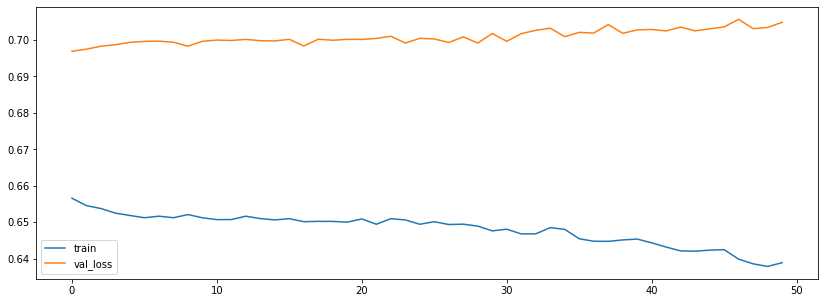

In [ ]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
# Extract dates (will be used in visualization)
datelist_train = list(train.datetime)
print(datelist_train)
# Select features (columns) to be involved intro training and predictions
cols = list(train)[1:8]
print(cols)

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

[Timestamp('2022-06-06 06:03:23+0000', tz='UTC'), Timestamp('2022-06-06 06:08:23+0000', tz='UTC'), Timestamp('2022-06-06 06:13:23+0000', tz='UTC'), Timestamp('2022-06-06 06:18:23+0000', tz='UTC'), Timestamp('2022-06-06 06:23:24+0000', tz='UTC'), Timestamp('2022-06-06 06:28:24+0000', tz='UTC'), Timestamp('2022-06-06 06:33:24+0000', tz='UTC'), Timestamp('2022-06-06 06:38:24+0000', tz='UTC'), Timestamp('2022-06-06 06:43:25+0000', tz='UTC'), Timestamp('2022-06-06 06:48:25+0000', tz='UTC'), Timestamp('2022-06-06 06:53:25+0000', tz='UTC'), Timestamp('2022-06-06 06:58:25+0000', tz='UTC'), Timestamp('2022-06-06 07:03:26+0000', tz='UTC'), Timestamp('2022-06-06 07:08:27+0000', tz='UTC'), Timestamp('2022-06-06 07:13:27+0000', tz='UTC'), Timestamp('2022-06-06 07:18:27+0000', tz='UTC'), Timestamp('2022-06-06 07:23:27+0000', tz='UTC'), Timestamp('2022-06-06 07:28:27+0000', tz='UTC'), Timestamp('2022-06-06 07:33:27+0000', tz='UTC'), Timestamp('2022-06-06 07:38:27+0000', tz='UTC'), Timestamp('2022-06-

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])
print(predictions_future)
predictions_train = model.predict(X_train[n_past:])



[[ 2.0546594e-01]
 [ 1.2914771e-01]
 [ 2.2919464e-01]
 [ 2.1827304e-01]
 [ 2.1801805e-01]
 [ 1.9560379e-01]
 [ 1.2717780e-01]
 [ 1.4685059e-01]
 [ 7.5180493e-02]
 [ 7.4515559e-02]
 [ 8.8826120e-03]
 [-7.9108864e-02]
 [ 2.2685528e-04]
 [-1.1862870e-01]
 [-1.9050831e-01]
 [-2.1784085e-01]
 [-2.0413205e-01]
 [-1.9831416e-01]
 [-1.4247078e-01]
 [-7.6352566e-02]
 [ 3.8080581e-02]
 [ 1.2473755e-01]
 [ 2.0014518e-01]
 [ 1.9959143e-01]
 [ 1.9253033e-01]
 [ 1.5315139e-01]
 [ 1.3714606e-01]
 [ 1.2908253e-01]
 [ 1.5123031e-01]
 [ 1.4918721e-01]
 [ 1.4059094e-01]
 [ 1.3237131e-01]
 [ 1.2824246e-01]
 [ 1.2145255e-01]
 [ 1.1414134e-01]
 [ 1.0981909e-01]
 [ 1.2742153e-01]
 [ 1.1282315e-01]
 [ 9.1425948e-02]
 [ 9.2125751e-02]
 [ 7.5975500e-02]
 [ 8.0321841e-02]
 [ 1.0147836e-01]
 [ 1.4630568e-01]
 [ 1.8653068e-01]
 [ 2.1647131e-01]
 [ 2.3218954e-01]
 [ 2.3754078e-01]
 [ 2.1399885e-01]
 [ 1.4108375e-01]
 [ 1.3634795e-01]
 [ 4.3000981e-02]
 [ 9.8112397e-02]
 [ 5.9989400e-02]
 [-1.2902141e-02]
 [ 5.21210

In [ ]:
import datetime as dt
from datetime import datetime

def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['value']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['value']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3) 


,value
2022-06-07,4.721979
2022-06-07,4.878181
2022-06-07,4.909197


In [ ]:
from google.colab import files
df_final_value = PREDICTIONS_FUTURE.value
df_final_value.to_csv('dfw_future_value_final.csv', encoding = 'utf-8-sig') 

files.download('dfw_future_value_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

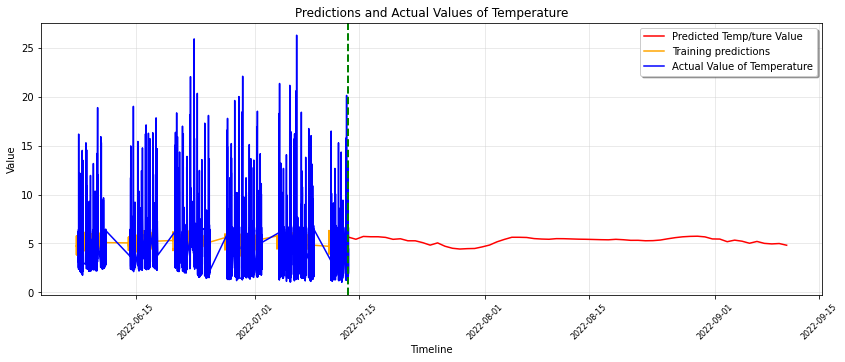

In [ ]:

# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2022-06-07'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['value'], color='r', label='Predicted Temp/ture Value')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['value'], color='orange', label='Training predictions')
plt.plot(train.loc[START_DATE_FOR_PLOTTING:].index, train.loc[START_DATE_FOR_PLOTTING:]['value'], color='b', label='Actual Value of Temperature')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Values of Temperature', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()
